# Collocation Optimal Control with Casadi
Objective: optimize a trajectory for a robot using the collocation approach.

## Standard Problem Formulation
$$ \min_{X, U} \quad \sum_{k=0}^{N-1} l_k(x_k, u_k) + l_N(x_N)$$
$$\text{subject to} \quad x_{k+1} = f(x_k, u_k) \quad \forall k \in [0, N-1]$$
$$ \qquad \qquad g_k(x_k, u_k) \le 0 \qquad \forall k \in [0, N-1]$$

# Modeling a Robot Manipulator
We use as state of the robot manipulator its joint positions and velocities:
$$ x = (q, \dot{q})$$
To start simple, we model the dynamics as a double integrator:
$$ \ddot{q} = u $$

# Introducing Casadi
Casadi is an open-source library for nonlinear optimization and algorithmic differentiation.

Let's implement the following optimal control problem:
$$ \min_{X, U} \quad \sum_{k=0}^{N-1} w_p ||q_k-q^d||^2 + w_v ||\dot{q}_k||^2 + w_a ||u_k||^2 + w_{p-final} ||q_N-q^d||^2 + w_{v-final} ||\dot{q}||^2$$
$$\text{subject to} \quad q_{k+1} = q_k + \Delta t \dot{q}_k \quad \forall k \in [0, N-1]$$
$$\qquad \qquad \dot{q}_{k+1} = \dot{q}_k + \Delta t u_k \quad \forall k \in [0, N-1]$$
$$ x_0 = x_{init} \qquad \qquad$$

In [1]:
import casadi as cs
import numpy as np
from numpy.random import rand

nu = nq = 3            # size of control vector
nx = 2*nq              # size of state vector
N = 30                 # horizon length
dt = 0.01              # time step length
x_init = np.zeros(nx)  # initial state
q_des = rand(nq)       # desired joint configuration
w_p = 1.0              # position weight
w_v = 1e-2             # velocity weight
w_a = 1e-4             # acceleration weight
w_p_final = 1.0        # position weight for terminal cost
w_v_final = 1.0        # velocity weight for terminal cost

In [2]:
# create all the decision variables
def create_decision_variables(N, nx, nu):
    opti = cs.Opti()
    X, U = [], []
    for k in range(N+1): 
        X += [opti.variable(nx)]
    for k in range(N): 
        U += [opti.variable(nu)]
    return opti, X, U

In [3]:
def define_running_cost_and_dynamics(opti, X, U, N, dt, x_init, q_des, w_p, w_v, w_a):
    opti.subject_to(X[0] == x_init)
    cost = 0.0
    for k in range(N):     
        # Compute cost function
        cost += w_p * (X[k][:nq] - q_des).T @ (X[k][:nq] - q_des) * dt 
        cost += w_v * X[k][nq:].T @ X[k][nq:] * dt
        cost += w_a * U[k].T @ U[k] * dt

        # Add dynamics constraints
        opti.subject_to(X[k+1][:nq] == X[k][:nq] + dt * X[k][nq:])
        opti.subject_to(X[k+1][nq:] == X[k][nq:] + dt * U[k])
    return cost

In [4]:
# add the terminal cost
def define_terminal_cost(X, q_des, w_p_final, w_v_final):
    cost = w_p_final * (X[-1][:nq] - q_des).T @ (X[-1][:nq] - q_des)
    cost += w_v_final * X[-1][nq:].T @ X[-1][nq:]
    return cost

In [5]:
opti, X, U = create_decision_variables(N, nx, nu)
running_cost = define_running_cost_and_dynamics(opti, X, U, N, dt, x_init, q_des, w_p, w_v, w_a)
terminal_cost = define_terminal_cost(X, q_des, w_p_final, w_v_final)
opti.minimize(running_cost + terminal_cost)

In [14]:
# Create the optimization problem
opts = {"ipopt.print_level": 0, "print_time": 0} # use this to remove prints when solving problem
opti.solver("ipopt") #, opts)

In [15]:
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      546
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      276

Total number of variables............................:      276
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      186
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1284236e+00 0.00e+00 6.38e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [8]:
x_sol = np.array([sol.value(X[k]) for k in range(N+1)]).T
u_sol = np.array([sol.value(U[k]) for k in range(N)]).T
q_sol = x_sol[:nq,:]
dq_sol = x_sol[nq:,:]

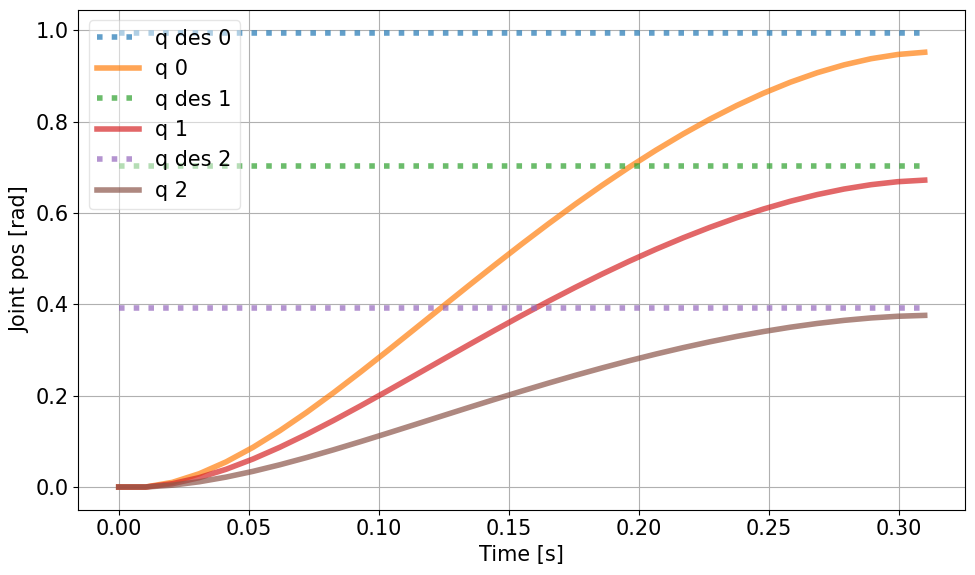

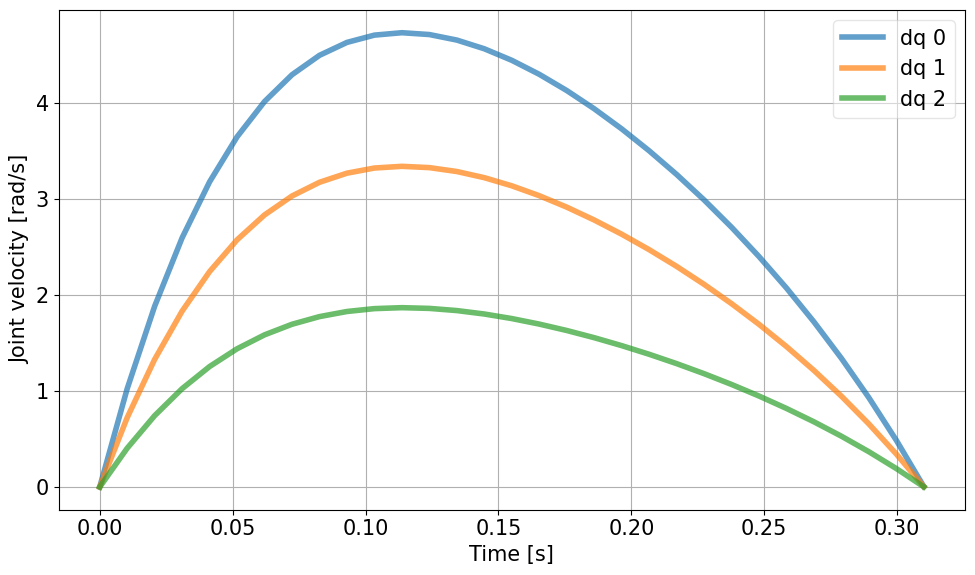

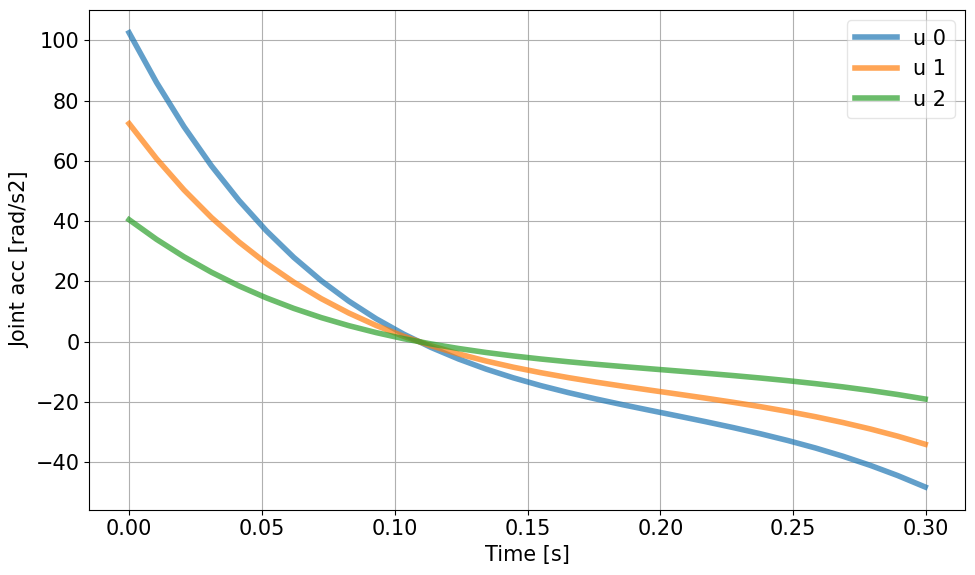

In [12]:
import matplotlib.pyplot as plt
import orc.utils.plot_utils as plut

tt = np.linspace(0, (N+1)*dt, N+1)

plt.figure(figsize=(10, 6))
for i in range(nq):
    plt.plot([tt[0], tt[-1]], [q_des[i], q_des[i]], ':', label=f'q des {i}', alpha=0.7)
    plt.plot(tt, q_sol[i,:].T, label=f'q {i}', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Joint pos [rad]')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
for i in range(nq):
    plt.plot(tt, dq_sol[i,:].T, label=f'dq {i}', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Joint velocity [rad/s]')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
for i in range(nq):
    plt.plot(tt[:-1], u_sol[i,:].T, label=f'u {i}', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Joint acc [rad/s2]')
plt.legend()
plt.grid(True)